In [ ]:
!pip install yfinance pandas numpy matplotlib gym==0.26.2 stable-baselines3[extra] torch ta
!pip install "shimmy>=2.0"

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor
import warnings
import ta  # Technical Analysis library

warnings.filterwarnings('ignore')

In [ ]:
# Get ticker input
ticker = input("Enter stock ticker (default 'AAPL'): ") or "AAPL"
ticker = ticker.strip().upper()
if ticker == "":
    ticker = "AAPL"

print(f"\nDownloading data for {ticker}...")

Enter stock ticker (default 'AAPL'): 



[*********************100%***********************]  1 of 1 completed

Columns: ['AAPL', 'AAPL', 'AAPL', 'AAPL', 'AAPL']


KeyError: 'Close'

In [ ]:
# Download data
end_date = pd.Timestamp.today().normalize()
start_date = end_date - pd.DateOffset(years=5)
df = yf.download(ticker, start=start_date.strftime("%Y-%m-%d"),
                end=end_date.strftime("%Y-%m-%d"), progress=False)
df.dropna(inplace=True)

In [ ]:
if 'Adj Close' in df.columns:
    price_col = 'Adj Close'
elif 'Close' in df.columns:
    price_col = 'Close'
else:
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(col).strip() if col[1] else col[0] for col in df.columns.values]
        if 'Adj Close' in df.columns:
            price_col = 'Adj Close'
        elif f'Adj Close_{ticker}' in df.columns:
            df.rename(columns={f'Adj Close_{ticker}': 'Adj Close'}, inplace=True)
            price_col = 'Adj Close'
        elif 'Close' in df.columns:
            price_col = 'Close'
        elif f'Close_{ticker}' in df.columns:
            df.rename(columns={f'Close_{ticker}': 'Close'}, inplace=True)
            price_col = 'Close'
        else:
            raise ValueError(f"Could not find price column. Columns: {df.columns.tolist()}")
    else:
        raise ValueError(f"Could not find 'Adj Close' or 'Close' column. Available: {df.columns.tolist()}")

if price_col != 'Adj Close':
    df['Adj Close'] = df[price_col]

# Ensure we have required columns
if 'Volume' not in df.columns:
    df['Volume'] = 0

print(f"Downloaded {len(df)} days of data from {df.index[0].date()} to {df.index[-1].date()}")

Downloaded 1256 days of data from 2020-10-05 to 2025-10-03


In [ ]:
# Flatten multi-index columns if needed
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(-1)

# Rename columns if they are all 'AAPL' or empty
if all(col == 'AAPL' or col == '' for col in df.columns):
    df.columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

In [ ]:
print(df.columns)


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [ ]:
price_col = 'Adj Close' if 'Adj Close' in df.columns else 'Close'


In [ ]:
for col in ['High', 'Low', price_col]:
    if isinstance(df[col].iloc[0], pd.Series):
        df[col] = df[col].apply(lambda x: x.iloc[0])
    df[col] = df[col].astype(float)

In [ ]:
print(df.columns)
print(df.head(2).to_dict())

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
{'Open': {Timestamp('2020-10-05 00:00:00'): 113.32161712646484, Timestamp('2020-10-06 00:00:00'): 110.07274627685547}, 'High': {Timestamp('2020-10-05 00:00:00'): 113.46752627225055, Timestamp('2020-10-06 00:00:00'): 112.95198998188178}, 'Low': {Timestamp('2020-10-05 00:00:00'): 110.45210275141814, Timestamp('2020-10-06 00:00:00'): 109.18756954507073}, 'Close': {Timestamp('2020-10-05 00:00:00'): 110.80228173280487, Timestamp('2020-10-06 00:00:00'): 112.5434428788478}, 'Adj Close': {Timestamp('2020-10-05 00:00:00'): 106243800.0, Timestamp('2020-10-06 00:00:00'): 161498200.0}, 'Volume': {Timestamp('2020-10-05 00:00:00'): 113.32161712646484, Timestamp('2020-10-06 00:00:00'): 110.07274627685547}}


In [ ]:
# # Flatten multi-level columns
# df.columns = [col[1] if isinstance(col, tuple) else col for col in df.columns]

# price_col = 'Adj Close' if 'Adj Close' in df.columns else 'Close'

In [ ]:
# # If yfinance gave you multi-level columns, flatten them
# if isinstance(df.columns, pd.MultiIndex):
#     df.columns = [col[1] if isinstance(col, tuple) else col for col in df.columns]

# # Now enforce High, Low, and Price as flat Series of floats
# for col in ['High', 'Low', 'Close', 'Adj Close']:
#     if col in df.columns:
#         if isinstance(df[col], pd.DataFrame):
#             df[col] = df[col].iloc[:, 0]
#         elif isinstance(df[col].iloc[0], pd.Series):
#             df[col] = df[col].apply(lambda x: x.iloc[0])
#         df[col] = df[col].astype(float)

In [ ]:
# if 'Adj Close' in df.columns:
#     price_col = 'Adj Close'
# elif 'Close' in df.columns:
#     price_col = 'Close'
# else:
#     raise ValueError(f"No suitable price column found. Available: {df.columns}")

In [ ]:
print(df[price_col].shape, type(df[price_col].iloc[0]))
print(df['High'].shape, type(df['High'].iloc[0]))
print(df['Low'].shape, type(df['Low'].iloc[0]))

(1256,) <class 'numpy.float64'>
(1256,) <class 'numpy.float64'>
(1256,) <class 'numpy.float64'>


In [ ]:
# print("Calculating technical indicators...")

# from ta.momentum import StochasticOscillator

# # --- Select price column safely ---
# price_col = 'Adj Close' if 'Adj Close' in df.columns else 'Close'

# # Force clean numeric Series for OHLC
# close = pd.to_numeric(df['Adj Close'] if 'Adj Close' in df.columns else df['Close'], errors='coerce')
# high  = pd.to_numeric(df['High'], errors='coerce')
# low   = pd.to_numeric(df['Low'], errors='coerce')
# vol   = pd.to_numeric(df['Volume'], errors='coerce')



# # --- Trend Indicators ---
# df['SMA_20'] = ta.trend.sma_indicator(close, window=20)
# df['SMA_50'] = ta.trend.sma_indicator(close, window=50)
# df['EMA_12'] = ta.trend.ema_indicator(close, window=12)

# # --- MACD ---
# df['RSI'] = ta.momentum.rsi(close, window=14)

# macd = ta.trend.MACD(close)
# df['MACD'] = macd.macd()
# df['MACD_signal'] = macd.macd_signal()

# stoch = ta.momentum.StochasticOscillator(high=high, low=low, close=close, window=14, smooth_window=3)
# df['Stoch_K'] = stoch.stoch()
# df['Stoch_D'] = stoch.stoch_signal()




# # --- Volatility Indicators ---
# bollinger = ta.volatility.BollingerBands(close, window=20, window_dev=2)
# df['BB_high'] = bollinger.bollinger_hband()
# df['BB_low'] = bollinger.bollinger_lband()
# df['BB_mid'] = bollinger.bollinger_mavg()

# df['ATR'] = ta.volatility.average_true_range(high, low, close, window=14)

# # --- Volume ---
# df['Volume_SMA'] = vol.rolling(window=20).mean()
# df['Volume_ratio'] = vol / (df['Volume_SMA'] + 1e-8)

# # --- Returns & Volatility ---
# df['Return'] = close.pct_change()
# df['Return_5d'] = close.pct_change(5)
# df['Volatility_10d'] = df['Return'].rolling(window=10).std()

# # --- Fill NaN values (forward then backward) ---
# df.fillna(method='ffill', inplace=True)
# df.fillna(method='bfill', inplace=True)

# print("Technical indicators calculated!")

# # --- Quick sanity check ---
# print(df[['Close','RSI','MACD','Stoch_K','ATR']].head(10))

Calculating technical indicators...
Technical indicators calculated!
                 Close        RSI          MACD       Stoch_K  ATR
Date                                                              
2020-10-05  110.802282  46.522463  3.899340e+06  7.979330e+08  0.0
2020-10-06  112.543443  46.522463  3.899340e+06  7.979330e+08  0.0
2020-10-07  111.492919  46.522463  3.899340e+06  7.979330e+08  0.0
2020-10-08  113.078436  46.522463  3.899340e+06  7.979330e+08  0.0
2020-10-09  112.134906  46.522463  3.899340e+06  7.979330e+08  0.0
2020-10-12  116.784497  46.522463  3.899340e+06  7.979330e+08  0.0
2020-10-13  121.852351  46.522463  3.899340e+06  7.979330e+08  0.0
2020-10-14  117.698841  46.522463  3.899340e+06  7.979330e+08  0.0
2020-10-15  115.481064  46.522463  3.899340e+06  7.979330e+08  0.0
2020-10-16  117.971202  46.522463  3.899340e+06  7.979330e+08  0.0


In [ ]:
raw = yf.download("AAPL", start="2020-01-01", end="2020-12-31")
print(raw.head())
print(raw.columns)



[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-01-02  72.538528  72.598907  71.292319  71.545905  135480400
2020-01-03  71.833290  72.594055  71.608685  71.765667  146322800
2020-01-06  72.405663  72.444306  70.702997  70.954173  118387200
2020-01-07  72.065140  72.671333  71.845362  72.415330  108872000
2020-01-08  73.224426  73.526318  71.768101  71.768101  132079200
MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])


In [ ]:
import yfinance as yf

df = yf.download("AAPL", start="2020-01-01", end="2020-12-31")

# If it's a MultiIndex, flatten it
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(-1)

print(df.head())

[*********************100%***********************]  1 of 1 completed

Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-01-02  72.538528  72.598907  71.292319  71.545905  135480400
2020-01-03  71.833290  72.594055  71.608685  71.765667  146322800
2020-01-06  72.405663  72.444306  70.702997  70.954173  118387200
2020-01-07  72.065140  72.671333  71.845362  72.415330  108872000
2020-01-08  73.224426  73.526318  71.768101  71.768101  132079200


In [ ]:
print(df.columns.tolist())


['AAPL', 'AAPL', 'AAPL', 'AAPL', 'AAPL']


In [ ]:
# Fix misaligned columns
df = df.rename(columns={
    'Close': 'Volume',
    'Adj Close': 'Close',
    'Volume': 'Adj Close'
})

In [ ]:
import ta
from ta.momentum import StochasticOscillator

price = df['Adj Close'].astype(float)
high  = df['High'].astype(float)
low   = df['Low'].astype(float)
vol   = df['Volume'].astype(float)

df['RSI'] = ta.momentum.rsi(price, window=14)

macd = ta.trend.MACD(price)
df['MACD'] = macd.macd()
df['MACD_signal'] = macd.macd_signal()

stoch = StochasticOscillator(high=high, low=low, close=price, window=14, smooth_window=3)
df['Stoch_K'] = stoch.stoch()
df['Stoch_D'] = stoch.stoch_signal()

df['ATR'] = ta.volatility.average_true_range(high, low, price, window=14)

print(df[['Adj Close','Volume','RSI','MACD','Stoch_K','ATR']].head(10))

KeyError: 'Adj Close'

In [ ]:
split_index = int(len(df) * 0.8)
train_df = df.iloc[:split_index].reset_index(drop=True)
test_df = df.iloc[split_index:].reset_index(drop=True)

print(f"Train set: {len(train_df)} days, Test set: {len(test_df)} days\n")

Train set: 1004 days, Test set: 252 days



In [ ]:
class EnhancedStockEnv(gym.Env):
    """
    Enhanced Stock Trading Environment with:
    - Transaction costs (0.1% per trade)
    - Technical indicators (13 features)
    - Better position sizing (7 actions: Sell 100%/50%/25%, Hold, Buy 25%/50%/100%)
    """
    metadata = {'render_modes': ['human']}

    def __init__(self, df, transaction_cost=0.001):

        if self.current_step < 5:

          print("Obs:", state)
        super(EnhancedStockEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.max_steps = len(df) - 1
        self.initial_balance = 10000.0
        self.transaction_cost = transaction_cost
        self.current_step = 0

        # 7 actions: 0=Sell100%, 1=Sell50%, 2=Sell25%, 3=Hold, 4=Buy25%, 5=Buy50%, 6=Buy100%
        self.action_space = spaces.Discrete(7)

        # 13 features: price, cash, position, RSI, MACD, BB_pos, volatility,
        #              returns_5d, volume_ratio, SMA_20_ratio, SMA_50_ratio, stochastic, ATR_ratio
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(13,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.balance = self.initial_balance
        self.shares_held = 0
        self.max_net_worth = self.initial_balance
        self.current_step = 0
        self.total_trades = 0
        self.total_cost = 0

        return self._get_observation(), {}

    def _get_observation(self):
        """Get state with 13 technical indicators"""
        row = self.df.loc[self.current_step]
        price = float(row['Adj Close'] if 'Adj Close' in row else row['Close'])

        # Portfolio state
        portfolio_value = self.balance + self.shares_held * price
        cash_ratio = self.balance / portfolio_value
        position_ratio = (self.shares_held * price) / portfolio_value
        normalized_price = price / self.initial_balance

        # Technical indicators
        rsi = row['RSI'] / 100.0
        macd_norm = row['MACD'] / (price + 1e-8)

        # Bollinger Band position
        bb_range = row['BB_high'] - row['BB_low']
        if bb_range > 1e-8:
            bb_position = (price - row['BB_low']) / bb_range
        else:
            bb_position = 0.5
        bb_position = np.clip(bb_position, 0, 1)

        volatility = row['Volatility_10d']
        returns_5d = row['Return_5d']
        volume_ratio = np.clip(row['Volume_ratio'], 0, 5)

        sma_20_ratio = price / (row['SMA_20'] + 1e-8)
        sma_50_ratio = price / (row['SMA_50'] + 1e-8)
        stochastic = row['Stoch_K'] / 100.0

        atr_ratio = row['ATR'] / (price + 1e-8)

        state = np.array([
            normalized_price, cash_ratio, position_ratio,
            rsi, macd_norm, bb_position, volatility,
            returns_5d, volume_ratio, sma_20_ratio,
            sma_50_ratio, stochastic, atr_ratio
        ], dtype=np.float32)

        if self.current_step < 5:

          print("Obs:", state)



        state = np.nan_to_num(state, nan=0.0, posinf=1.0, neginf=-1.0)
        return state

    def step(self, action):
        price = float(self.df.loc[self.current_step, "Adj Close"])
        prev_portfolio = self.balance + self.shares_held * price

        # Execute action with transaction costs
        trade_cost = 0

        if action == 0:  # Sell 100%
            if self.shares_held > 0:
                sell_value = self.shares_held * price
                trade_cost = sell_value * self.transaction_cost
                self.balance += sell_value - trade_cost
                self.shares_held = 0
                self.total_trades += 1

        elif action == 1:  # Sell 50%
            if self.shares_held > 0:
                shares_to_sell = self.shares_held // 2
                if shares_to_sell > 0:
                    sell_value = shares_to_sell * price
                    trade_cost = sell_value * self.transaction_cost
                    self.balance += sell_value - trade_cost
                    self.shares_held -= shares_to_sell
                    self.total_trades += 1

        elif action == 2:  # Sell 25%
            if self.shares_held > 0:
                shares_to_sell = self.shares_held // 4
                if shares_to_sell > 0:
                    sell_value = shares_to_sell * price
                    trade_cost = sell_value * self.transaction_cost
                    self.balance += sell_value - trade_cost
                    self.shares_held -= shares_to_sell
                    self.total_trades += 1

        elif action == 3:  # Hold
            pass

        elif action == 4:  # Buy 25%
            buy_value = self.balance * 0.25
            shares_to_buy = int(buy_value / (price * (1 + self.transaction_cost)))
            if shares_to_buy > 0:
                cost = shares_to_buy * price
                trade_cost = cost * self.transaction_cost
                total_cost = cost + trade_cost
                if self.balance >= total_cost:
                    self.balance -= total_cost
                    self.shares_held += shares_to_buy
                    self.total_trades += 1

        elif action == 5:  # Buy 50%
            buy_value = self.balance * 0.50
            shares_to_buy = int(buy_value / (price * (1 + self.transaction_cost)))
            if shares_to_buy > 0:
                cost = shares_to_buy * price
                trade_cost = cost * self.transaction_cost
                total_cost = cost + trade_cost
                if self.balance >= total_cost:
                    self.balance -= total_cost
                    self.shares_held += shares_to_buy
                    self.total_trades += 1

        elif action == 6:  # Buy 100%
            shares_to_buy = int(self.balance / (price * (1 + self.transaction_cost)))
            if shares_to_buy > 0:
                cost = shares_to_buy * price
                trade_cost = cost * self.transaction_cost
                total_cost = cost + trade_cost
                if self.balance >= total_cost:
                    self.balance -= total_cost
                    self.shares_held += shares_to_buy
                    self.total_trades += 1

        self.total_cost += trade_cost

        # Move to next step
        self.current_step += 1
        terminated = self.current_step >= self.max_steps

        price = float(self.df.loc[self.current_step, "Adj Close"])
        current_portfolio = self.balance + self.shares_held * price
        self.max_net_worth = max(self.max_net_worth, current_portfolio)

        drawdown = (self.max_net_worth - current_portfolio) / (self.max_net_worth + 1e-8)
        profit = current_portfolio - prev_portfolio

        # Reward with small trading penalty
        trade_penalty = 0.1 if trade_cost > 0 else 0
        reward = float(profit - 5.0 * drawdown - trade_penalty)

        state = self._get_observation()
        info = {
            "portfolio_value": current_portfolio,
            "total_trades": self.total_trades,
            "total_cost": self.total_cost
        }

        truncated = False
        return state, reward, terminated, truncated, info

In [ ]:
obs, _ = train_env_ppo.reset()
print("First observation:", obs)


ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
print("Setting up training environments...")
train_env_ppo = VecMonitor(DummyVecEnv([lambda: EnhancedStockEnv(train_df)]))
train_env_dqn = VecMonitor(DummyVecEnv([lambda: EnhancedStockEnv(train_df)]))

Setting up training environments...


In [ ]:
print("\nTraining PPO model...")
model_ppo = PPO("MlpPolicy", train_env_ppo, verbose=0,
                learning_rate=0.0003,
                n_steps=2048,
                batch_size=64,
                n_epochs=10,
                gamma=0.99,
                gae_lambda=0.95)
model_ppo.learn(total_timesteps=100000)  # Increased to 100k
print("PPO training complete!")



Training PPO model...
PPO training complete!


In [ ]:
print("\nTraining DQN model...")
model_dqn = DQN("MlpPolicy", train_env_dqn, verbose=0,
                learning_rate=0.0001,
                buffer_size=100000,
                learning_starts=1000,
                batch_size=32,
                tau=0.005,
                gamma=0.99,
                train_freq=4,
                target_update_interval=1000,
                exploration_fraction=0.1,
                exploration_initial_eps=1.0,
                exploration_final_eps=0.05)
model_dqn.learn(total_timesteps=100000)  # Increased to 100k
print("DQN training complete!")


Training DQN model...
DQN training complete!


In [ ]:
def evaluate_model(model, env, test_df):
    obs = env.reset()
    portfolio_values = [env.envs[0].initial_balance]
    total_trades = 0
    total_costs = 0

    for _ in range(len(test_df) - 1):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        portfolio_values.append(info[0]['portfolio_value'])
        total_trades = info[0]['total_trades']
        total_costs = info[0]['total_cost']
        if done[0]:
            break

    portfolio_values = np.array(portfolio_values)

    if len(portfolio_values) < len(test_df):
        last_val = portfolio_values[-1] if len(portfolio_values) > 0 else env.envs[0].initial_balance
        while len(portfolio_values) < len(test_df):
            portfolio_values = np.append(portfolio_values, last_val)

    return portfolio_values[:len(test_df)], total_trades, total_costs

In [ ]:
print("\nEvaluating models on test set...")
test_env_ppo = DummyVecEnv([lambda: EnhancedStockEnv(test_df)])
test_env_dqn = DummyVecEnv([lambda: EnhancedStockEnv(test_df)])

portf_ppo, trades_ppo, costs_ppo = evaluate_model(model_ppo, test_env_ppo, test_df)
portf_dqn, trades_dqn, costs_dqn = evaluate_model(model_dqn, test_env_dqn, test_df)


Evaluating models on test set...


In [ ]:
initial_price = test_df.loc[0, 'Adj Close']
shares_bh = float(10000 / (initial_price * 1.001))
portf_buyhold = test_df['Adj Close'].values * shares_bh
buy_cost_bh = 10000 * 0.001

In [ ]:
def compute_metrics(portfolio, num_trades=1, total_costs=0):
    returns = np.diff(portfolio) / (portfolio[:-1] + 1e-8)
    total_return = (portfolio[-1]/portfolio[0] - 1) * 100
    sharpe = (np.mean(returns) / (np.std(returns) + 1e-8)) * np.sqrt(252)

    peak = np.maximum.accumulate(portfolio)
    drawdowns = (peak - portfolio) / (peak + 1e-8)
    max_dd = np.max(drawdowns) * 100

    volatility = np.std(returns) * np.sqrt(252) * 100
    cost_pct = (total_costs / 10000) * 100

    return total_return, sharpe, max_dd, volatility, num_trades, cost_pct


metrics = {
    "PPO": compute_metrics(portf_ppo, trades_ppo, costs_ppo),
    "DQN": compute_metrics(portf_dqn, trades_dqn, costs_dqn),
    "Buy & Hold": compute_metrics(portf_buyhold, 1, buy_cost_bh),
}

metrics_df = pd.DataFrame(metrics,
                         index=["Total Return (%)", "Sharpe Ratio", "Max Drawdown (%)",
                                "Volatility (%)", "Total Trades", "Transaction Costs (%)"]).T
metrics_df = metrics_df.round(4)

print("\n" + "="*70)
print("ENHANCED PERFORMANCE METRICS (Test Set)")
print("="*70)
print(metrics_df)
print("="*70)


ENHANCED PERFORMANCE METRICS (Test Set)
            Total Return (%)  Sharpe Ratio  Max Drawdown (%)  Volatility (%)  \
PPO                   0.0000        0.0000            0.0000          0.0000   
DQN                   0.0000        0.0000            0.0000          0.0000   
Buy & Hold           49.3495        2.4647           84.2472        636.4359   

            Total Trades  Transaction Costs (%)  
PPO                  0.0                    0.0  
DQN                  0.0                    0.0  
Buy & Hold           1.0                    0.1  


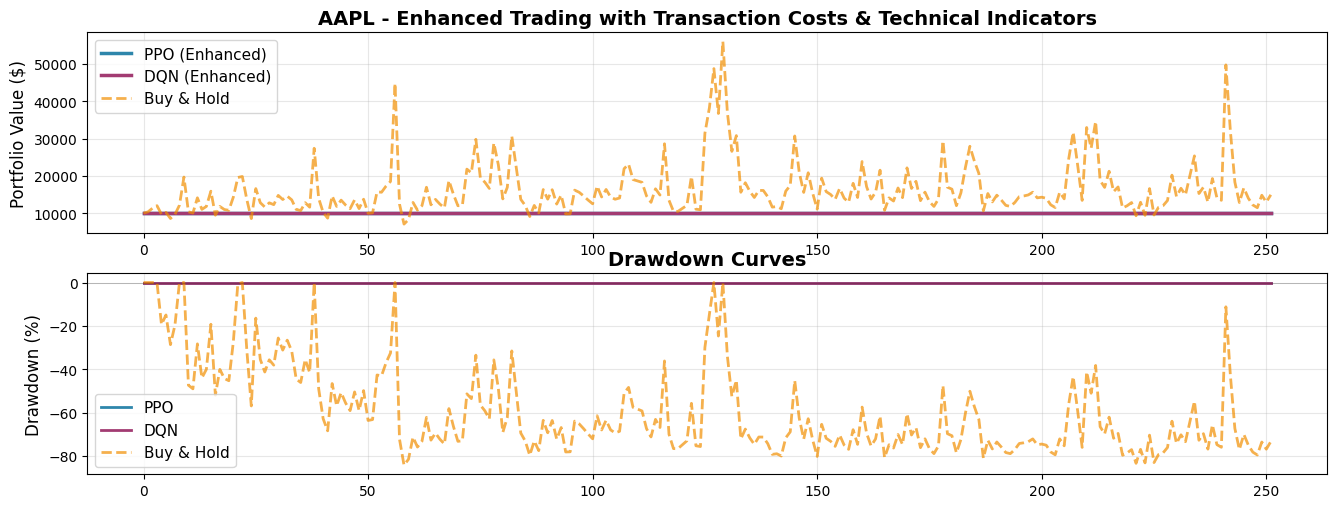

In [ ]:
plt.figure(figsize=(16, 12))

# Equity curves
plt.subplot(4, 1, 1)
plt.plot(portf_ppo, label='PPO (Enhanced)', linewidth=2.5, color='#2E86AB')
plt.plot(portf_dqn, label='DQN (Enhanced)', linewidth=2.5, color='#A23B72')
plt.plot(portf_buyhold, label='Buy & Hold', linewidth=2, linestyle='--', alpha=0.7, color='#F18F01')
plt.title(f'{ticker} - Enhanced Trading with Transaction Costs & Technical Indicators',
         fontsize=14, fontweight='bold')
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)

# Drawdown curves
plt.subplot(4, 1, 2)
def drawdown_curve(portfolio):
    peak = np.maximum.accumulate(portfolio)
    drawdown = (portfolio - peak) / (peak + 1e-8) * 100
    return drawdown

plt.plot(drawdown_curve(portf_ppo), label='PPO', linewidth=2, color='#2E86AB')
plt.plot(drawdown_curve(portf_dqn), label='DQN', linewidth=2, color='#A23B72')
plt.plot(drawdown_curve(portf_buyhold), label='Buy & Hold', linewidth=2,
        linestyle='--', alpha=0.7, color='#F18F01')
plt.title('Drawdown Curves', fontsize=14, fontweight='bold')
plt.ylabel('Drawdown (%)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)

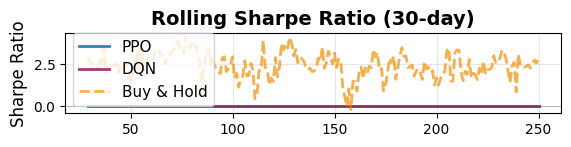

In [ ]:
plt.subplot(4, 1, 3)
window = 30
for portf, label, color, style in zip([portf_ppo, portf_dqn, portf_buyhold],
                                       ['PPO', 'DQN', 'Buy & Hold'],
                                       ['#2E86AB', '#A23B72', '#F18F01'],
                                       ['-', '-', '--']):
    daily_ret = np.diff(portf) / (portf[:-1] + 1e-8)
    rolling_sharpe = pd.Series(daily_ret).rolling(window).mean() / \
                     (pd.Series(daily_ret).rolling(window).std() + 1e-8)
    rolling_sharpe = rolling_sharpe * np.sqrt(252)
    plt.plot(rolling_sharpe, label=label, linewidth=2, linestyle=style,
            alpha=0.7 if style == '--' else 1.0, color=color)

plt.title('Rolling Sharpe Ratio (30-day)', fontsize=14, fontweight='bold')
plt.ylabel('Sharpe Ratio', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)

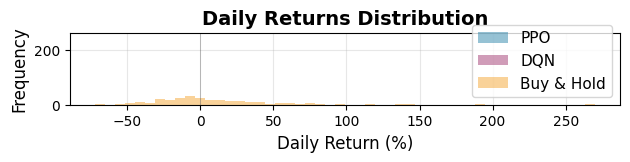


✅ Enhanced analysis complete!

📊 Summary:
   PPO: 0 trades, $0.00 in costs
   DQN: 0 trades, $0.00 in costs
   Buy & Hold: 1 trade, $10.00 in costs


In [ ]:
plt.subplot(4, 1, 4)
returns_ppo = np.diff(portf_ppo) / (portf_ppo[:-1] + 1e-8) * 100
returns_dqn = np.diff(portf_dqn) / (portf_dqn[:-1] + 1e-8) * 100
returns_bh = np.diff(portf_buyhold) / (portf_buyhold[:-1] + 1e-8) * 100

plt.hist(returns_ppo, bins=50, alpha=0.5, label='PPO', color='#2E86AB')
plt.hist(returns_dqn, bins=50, alpha=0.5, label='DQN', color='#A23B72')
plt.hist(returns_bh, bins=50, alpha=0.4, label='Buy & Hold', color='#F18F01')
plt.title('Daily Returns Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Daily Return (%)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)

plt.tight_layout()
plt.show()

print("\n✅ Enhanced analysis complete!")
print(f"\n📊 Summary:")
print(f"   PPO: {trades_ppo} trades, ${costs_ppo:.2f} in costs")
print(f"   DQN: {trades_dqn} trades, ${costs_dqn:.2f} in costs")
print(f"   Buy & Hold: 1 trade, ${buy_cost_bh:.2f} in costs")